In [1]:
import os

HF_HOME = "G:\huggingface"
os.environ["HF_DATASETS_CACHE"] = HF_HOME
os.environ["HF_HOME"] = HF_HOME
os.environ["HF_HUB_CACHE  "] = HF_HOME 

In [2]:
from pathlib import Path

from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.converters import TextFileToDocument
from haystack.components.embedders import (
    SentenceTransformersDocumentEmbedder,
    SentenceTransformersTextEmbedder,
)
from haystack.components.generators.chat import HuggingFaceLocalChatGenerator
from haystack.components.generators import HuggingFaceLocalGenerator

from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack_integrations.components.retrievers.chroma import ChromaEmbeddingRetriever
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
from haystack.utils import ComponentDevice
from haystack.components.converters.pypdf import PyPDFToDocument
from haystack.components.builders import AnswerBuilder


gpu = ComponentDevice.from_str("cuda")
cpu = ComponentDevice.from_str("cpu")
context_directory = list(Path("../data").iterdir())
document_store = ChromaDocumentStore(persist_path=".")


In [15]:
pdf_converter = PyPDFToDocument()

text_file_converter = TextFileToDocument()
cleaner = DocumentCleaner(remove_extra_whitespaces=True)
splitter = DocumentSplitter(split_length=15, split_by="sentence", split_overlap=2)
embedder = SentenceTransformersDocumentEmbedder(
    model="mixedbread-ai/mxbai-embed-large-v1", progress_bar=True, device=gpu, batch_size=100
)
embedder.device = cpu
embedder.warm_up()

writer = DocumentWriter(document_store)

indexing_pipeline = Pipeline()
indexing_pipeline.add_component("converter", pdf_converter)
indexing_pipeline.add_component("cleaner", cleaner)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

indexing_pipeline.connect("converter.documents", "cleaner.documents")
indexing_pipeline.connect("cleaner.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")
indexing_pipeline.run(data={"sources": context_directory})


KeyboardInterrupt: 

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The model 'MistralForCausalLM' is not supported for text2text-generation. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PL

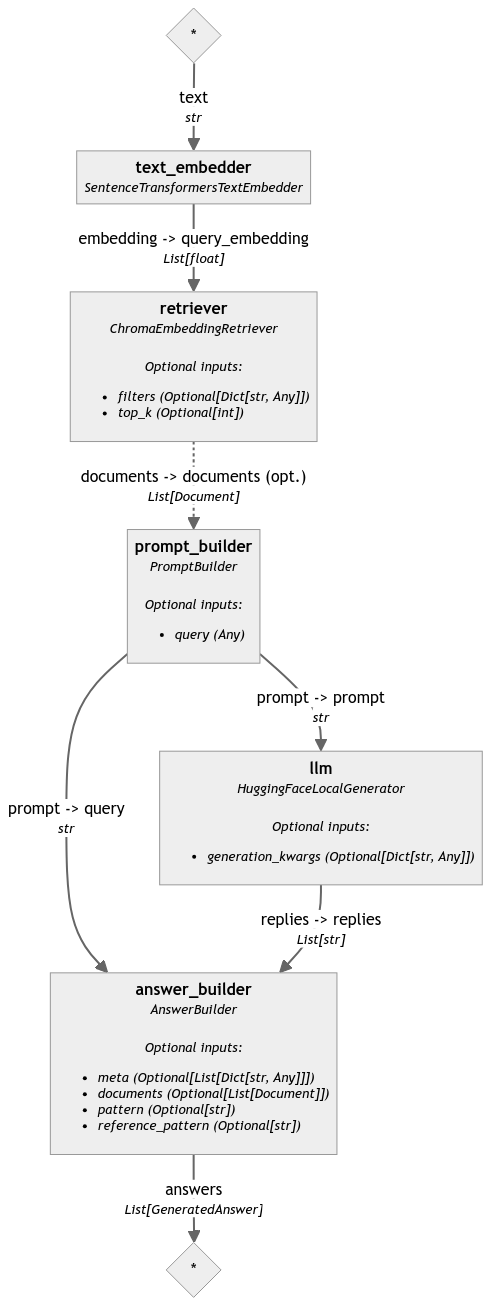

In [3]:
text_embedder = SentenceTransformersTextEmbedder(
    model="mixedbread-ai/mxbai-embed-large-v1", progress_bar=True, device=cpu
)
retriever = ChromaEmbeddingRetriever(document_store)
template = """Given these documents, answer the question.
              Documents:
              {% for doc in documents %}
                  {{ doc.content }}
              {% endfor %}
              Question: {{query}}
              Answer:"""
prompt_builder = PromptBuilder(template=template)
answer_builder = AnswerBuilder(pattern="Answer: (.*)")

generator = HuggingFaceLocalGenerator(model='TheBloke/OpenHermes-2.5-Mistral-7B-16k-AWQ', device=gpu, task='text2text-generation', 
                                      generation_kwargs={'max_new_tokens': 300})
generator.warm_up()


rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)
rag_pipeline.add_component("answer_builder", answer_builder)


rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever.documents", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")
rag_pipeline.connect("llm.replies", "answer_builder.replies")
rag_pipeline.connect("prompt_builder", "answer_builder.query")


In [7]:
query = "What were the net sales last year?"
result = rag_pipeline.run(
    data={"prompt_builder": {"query": query}, "text_embedder": {"text": query}}
)
print(result['answer_builder']['answers'][0].data)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.


The net sales last year were €10,105 million.


In [5]:
print(result['answer_builder']['answers'][0].data)


{'answer_builder': {'answers': [GeneratedAnswer(data='The net sales last year were €10,105 million.', query="Given these documents, answer the question.\n              Documents:\n              \n                   UNDERLYING FIGURES PER SEGMENT\nSEGMENT OVERVIEW\n(in € million)\nFY 2022 FY 2021 % yoy % organic\nNet sales 13,426 10,105 +32.9% +25.6%\nMaterials 4,075 2,903 +40.4% +32.6% Specialty Polymers 3,121 2,173 +43.6% +36.6% Composite Materials 954 730 +30.7% +21.0%\nChemicals 4,496 3,357 +33.9% +26.5% Soda Ash & Derivatives 2,221 1,509 +47.2% +40.7% Peroxides 773 636 +21.6% +16.8% Coatis 870 745 +16.\n              \n                  \nIn € million 2022 2021\nMaterials 4,075 2,903\nSpecialty Polymers 3,121 2,173\nComposite Materials 954 730\nChemicals 4,496 3,357\nSoda Ash & Derivatives 2,221 1,509\nPeroxides 773 636\nSilica 631 467\nCoatis 870 745\nSolutions 4,846 3,838\nNovecare 1,905 1,547\nSpecial Chem 1,040 840\nTechnology Solutions 740 560\nAroma Performance 575 473\nOil a